In [1]:
%matplotlib inline

import os
import warnings
import collections
import time
from datetime import timedelta

import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates

import plot_functions as pfn
import pandas as pd
import numpy as np
import seaborn as sns

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH '] = '1'

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

from pandas.plotting import register_matplotlib_converters

import util_functions as util

register_matplotlib_converters()
sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

warnings.filterwarnings('ignore')

# show gpu status, fix memory growth
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:

    try:

        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "physical GPUs,", len(logical_gpus), "logical GPUs", logical_gpus)

    except RuntimeError as e:
        print(e)

print( 'tf version :', tf.__version__ )
print( 'tfp version:', tfp.__version__ )


1 physical GPUs, 1 logical GPUs [LogicalDevice(name='/device:GPU:0', device_type='GPU')]
tf version : 2.1.0
tfp version: 0.9.0


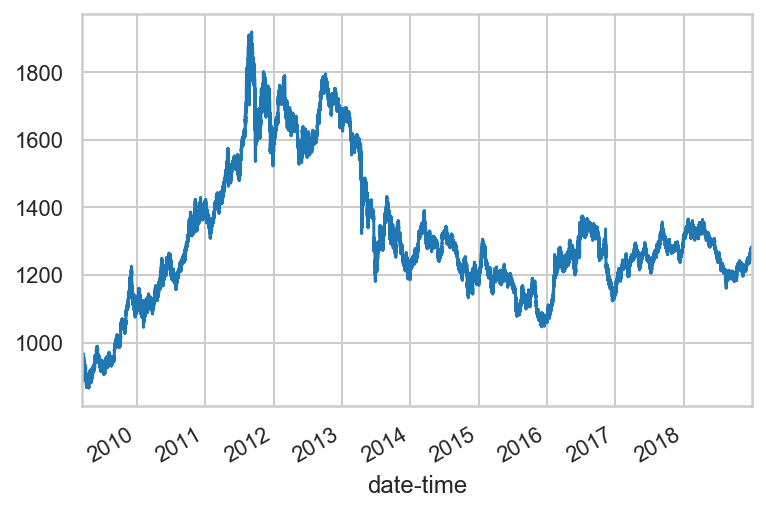

In [2]:

dataset_headers = ['date-time','O','H','L','C','V']
dataset_dtype = 'float32'
dataset_dtypes = {'O':dataset_dtype,'H':dataset_dtype,'L':dataset_dtype,'C':dataset_dtype,'V':'int32'}
dataset_file = '../../../lambda-asset-corpus/ALL/XAUUSD_1M_ALL.csv'
dataset_sep = ';'

dataset = pd.read_csv( dataset_file, sep=dataset_sep, names=dataset_headers, dtype=dataset_dtypes )

# e.g., 20090315 181200
dataset['date-time'] =  pd.to_datetime( dataset['date-time'], format='%Y%m%d %H%M%S')
dataset = dataset.set_index( ['date-time'] )

#dataset = dataset.resample('D').pad()
dataset.tail()
_ = dataset['C'].plot()


In [3]:
#signal = util.zigzag( dataset, pct=0.01 )['ZZ']
signal = dataset['C']

slow = 14400

slow_rsd = signal.rolling( slow ).std()
slow_rmean = signal.rolling( slow ).mean()
slow_z = ( ( signal - slow_rmean ) / slow_rsd )

fast = 1440

fast_rsd = signal.rolling( fast ).std()
fast_rmean = signal.rolling( fast ).mean()
fast_z = ( ( signal - fast_rmean ) / fast_rsd )


In [4]:
window=144000
z = fast_z

#hist, edges = np.histogram( z[-window:], bins=np.arange(-5.0,5.0,step=10/1000) )
hist, edges = np.histogram( z[-window:], bins=np.arange(z.min(),z.max(),step=10/1000) )
histogram = pd.DataFrame( hist )
histlist = list(hist)

inverse_hist = (-hist+hist.max())/hist.max()

half = int(len(edges)/2)

xleft = np.max(hist[0:half])
for i in range(0,half):
    if hist[i] == xleft:
        ileft = i
        break

xright = np.max(hist[half:half*2])
for i in range(half,half*2):
    if hist[i] == xright:
        iright = i
        break

print('maxz',z.max(),'minz',z.min())
print('left',edges[ileft],'right',edges[iright])
print('sum',hist.sum(),'max',hist.max())
print('lmin',edges.min(),'lmax',edges.max())


maxz 12.094423347218559 minz -14.094474503720363
left -1.0244745037206417 right 0.8255254962793188
sum 144000 max 438
lmin -14.094474503720363 lmax 12.085525496279079


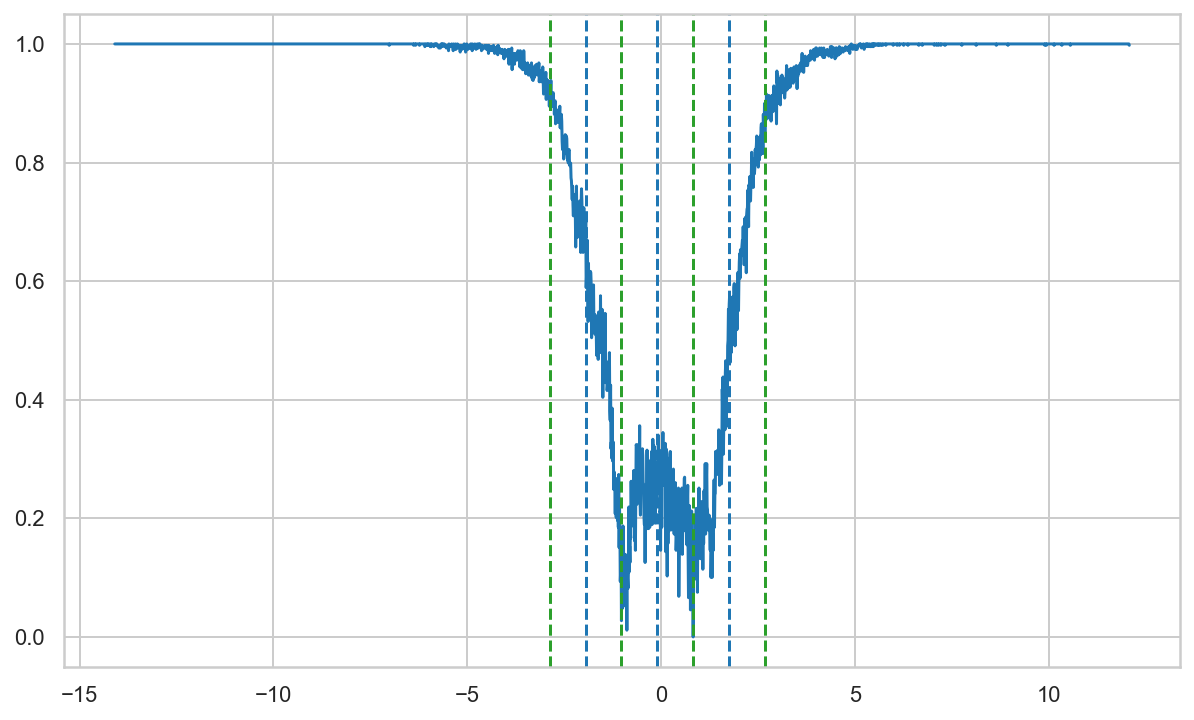

In [5]:
rmean_hist = histogram # .rolling( 1 ).mean()
mean_rmean_hist = rmean_hist.mean()

colors = sns.color_palette()
c1, c2, c3 = colors[0], colors[1], colors[2]
fig = plt.figure( figsize=(10, 6) )
ax = fig.add_subplot(1, 1, 1)

#_ = ax.plot( edges[0:-1], ( -hist+hist.max() ) / hist.max() )
_ = ax.plot( edges[0:-1], inverse_hist )

_ = ax.axvline( edges[ileft], linestyle="--", color=c3 )
_ = ax.axvline( edges[iright], linestyle="--", color=c3 )

center = ( edges[ileft] + edges[iright] ) / 2.0
step = edges[iright] - center
left = edges[ileft]
right = edges[iright]

_ = ax.axvline( center, linestyle="--" )
_ = ax.axvline( right + step * 1.0, linestyle="--" )
_ = ax.axvline( right + step * 2.0, linestyle="--", color=c3 )

_ = ax.axvline( left - step * 1.0, linestyle="--" )
_ = ax.axvline( left - step * 2.0, linestyle="--", color=c3 )


In [6]:
final_window=1440
fast_r = signal[-final_window:] - fast_rmean[-final_window:]
final_r = []
for i in range(len(fast_r)):
    index = 0
    multi = 0
    for j in range(len(edges)-1):
        if fast_r[i]>edges[j] and fast_r[i]<edges[j+1]:
            index = j
            multi = (-hist[j]+hist.max())/hist.max()
            #multi = hist[j]/hist.max()
            break
    final_r.append(fast_r[i]*multi)
    


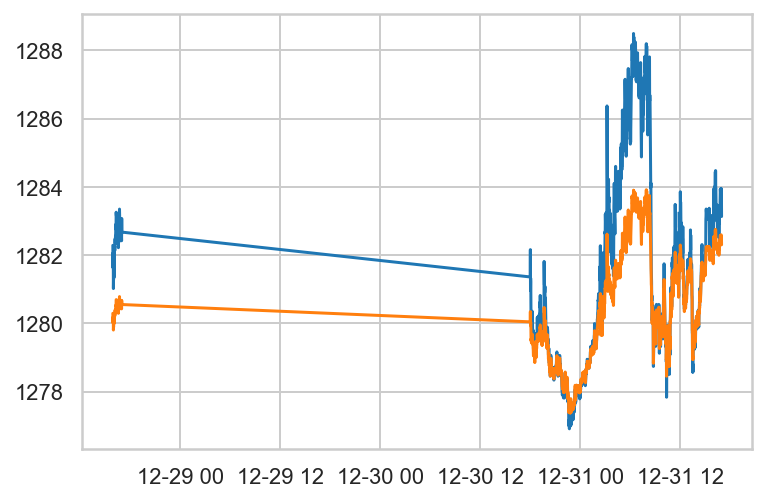

In [45]:
plt.plot(signal[-final_window:]+final_r)
plt.plot(signal[-final_window:])
